# 2. Mambaについてもう少し

In [65]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [163]:
using Distributions
@everywhere using Mamba
using LaTeXStrings
using Plots
using Printf

## 同じ物語、異なる結末
ユーザーの振る舞いが変化する変化点のサンプリング

In [2]:
tau = rand(DiscreteUniform(0, 80))

26

指数分布$\text{Exp}(\alpha)$から$\lambda_1$と$\lambda_2$をサンプリング。パラメトライズがPyMCと違うことに注意

In [8]:
theta = 20
lambda_1, lambda_2 = rand(Exponential(theta), 2)

2-element Array{Float64,1}:
  4.213585844431157
 15.104817169175416

日付$\tau$より前は$\lambda=\lambda_1$, 日付$\tau$より後は$\lambda=\lambda_2$とする

In [9]:
lambda_ = cat(fill(lambda_1, tau), fill(lambda_2, 80 - tau), dims = 1)

80-element Array{Float64,1}:
  4.213585844431157
  4.213585844431157
  4.213585844431157
  4.213585844431157
  4.213585844431157
  4.213585844431157
  4.213585844431157
  4.213585844431157
  4.213585844431157
  4.213585844431157
  4.213585844431157
  4.213585844431157
  4.213585844431157
  ⋮                
 15.104817169175416
 15.104817169175416
 15.104817169175416
 15.104817169175416
 15.104817169175416
 15.104817169175416
 15.104817169175416
 15.104817169175416
 15.104817169175416
 15.104817169175416
 15.104817169175416
 15.104817169175416

$\text{Poisson}(\lambda_1), \text{Poisson}(\lambda_2)$からサンプリングする

In [10]:
data = @.rand(Poisson(lambda_))

80-element Array{Int64,1}:
  4
  4
  2
  3
  4
  2
  6
  3
  6
  1
  5
  2
  3
  ⋮
 16
 11
 15
 13
 13
 18
 19
 20
 11
 20
 21
 11

プロットする。オレンジが変化点

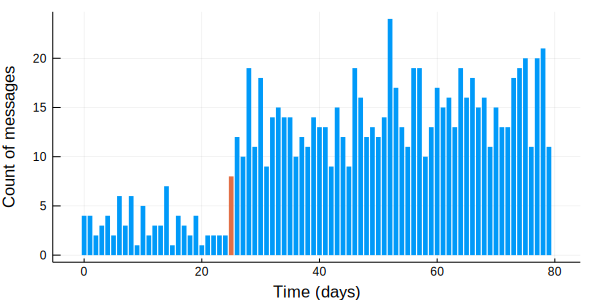

In [15]:
barc = fill(1, 80)
barc[tau] = 2
bar(0:80-1, data, size = [600, 300], linecolor = :transparent, fillcolor = barc,
    xlabel = "Time (days)", ylabel = "Count of messages", label = "")

In [61]:
function plot_artificial_sms_dataset()
    tau = rand(DiscreteUniform(0, 80))
    theta = 20
    lambda_1, lambda_2 = rand(Exponential(theta), 2)
    lambda_ = cat(fill(lambda_1, tau), fill(lambda_2, 80 - tau), dims = 1)
    data = @.rand(Poisson(lambda_))
    barc = fill(1, 80)
    barc[tau] = 2
    bar(0:80-1, data, linecolor = :transparent, fillcolor = barc,
        xlabel = "Time (days)", ylabel = "Count of messages", label = "")
end

plot_artificial_sms_dataset (generic function with 1 method)

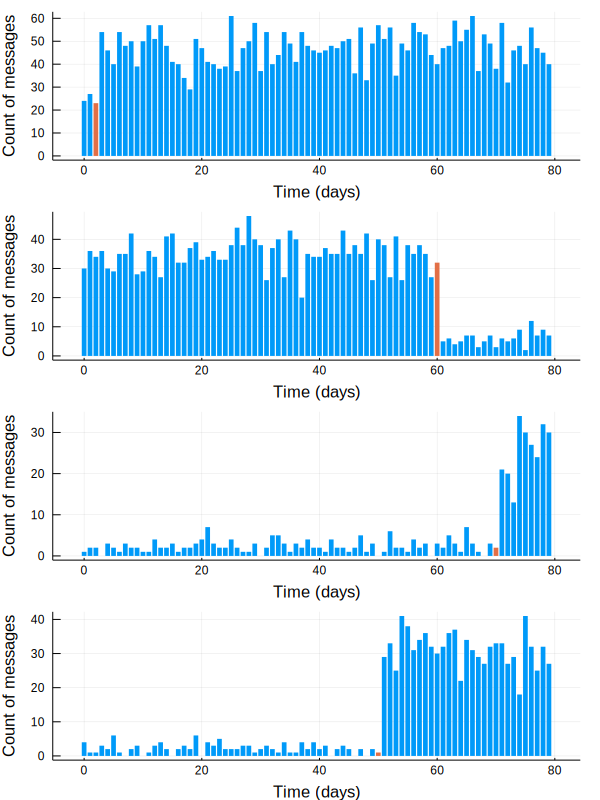

In [63]:
plts = []
for i in 1:4
    push!(plts, plot_artificial_sms_dataset())
end
plot(plts..., layout = (4, 1), size = [600, 800])

## 例題: ベイズ的 A/Bテスト
サイトAを見せられたユーザーが最終的にコンバージョンにつながる確率を$p_A$と仮定し、$N$人がサイトAを見せられて、そのうち$n$人がコンバージョンにつながったとする。

In [140]:
# 定数をセット
p_true = 0.05
N = 1500

occurrences = rand(Bernoulli(p_true), N)

1500-element Array{Int64,1}:
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 1
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0

In [141]:
sum(occurrences)

83

In [142]:
println("The observed frequency: ", mean(occurrences))
println("Does the observed frequence equal to the true frequency? ", mean(occurrences) == p_true)

The observed frequency: 0.05533333333333333
Does the observed frequence equal to the true frequency? false


In [143]:
model0 = Model(
    obs = Stochastic(1, 
        (p, N) -> UnivariateDistribution[Bernoulli(p) for _ in 1:N], false),
    p = Stochastic(() -> Uniform()),
)

Object of type "Model"
-------------------------------------------------------------------------------
p:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [144]:
data0 = Dict{Symbol, Any}(
    :obs => occurrences,
    :N => N,
)

Dict{Symbol,Any} with 2 entries:
  :N   => 1500
  :obs => [0, 0, 0, 1, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [145]:
inits0 = [
    Dict{Symbol, Any}(
        :obs => occurrences,
        :p => rand(Uniform()),
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:p=>0.918304,:obs=>[0, 0, 0, 1, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 1, 0, 0, 0]) 
 Dict(:p=>0.0500007,:obs=>[0, 0, 0, 1, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
 Dict(:p=>0.346914,:obs=>[0, 0, 0, 1, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 1, 0, 0, 0]) 

In [146]:
scheme0 = [NUTS(:p)]

1-element Array{Sampler{Mamba.NUTSTune},1}:
 An object of type "Sampler{Mamba.NUTSTune}"
Sampling Block Nodes:
Symbol[:p]

CodeInfo(
1 ─ %1 = π (##270#272{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}}(:forward, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}()), Const(##270#272{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}}(:forward, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}()), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [147]:
setsamplers!(model0, scheme0)
sim0 = mcmc(model0, data0, inits0, 20000, burnin = 1000, thin = 1, chains = 3)

MCMC Simulation of 20000 Iterations x 3 Chains...

      From worker 2:	Chain 3:   0% [0:01:31 of 0:01:31 remaining]
      From worker 3:	Chain 2:   0% [0:01:22 of 0:01:22 remaining]
      From worker 4:	Chain 1:   0% [0:01:45 of 0:01:45 remaining]
      From worker 3:	Chain 2:  10% [0:00:38 of 0:00:43 remaining]
      From worker 4:	Chain 1:  10% [0:00:39 of 0:00:43 remaining]
      From worker 2:	Chain 3:  10% [0:00:40 of 0:00:44 remaining]
      From worker 4:	Chain 1:  20% [0:00:33 of 0:00:41 remaining]
      From worker 3:	Chain 2:  20% [0:00:33 of 0:00:41 remaining]
      From worker 2:	Chain 3:  20% [0:00:33 of 0:00:41 remaining]
      From worker 2:	Chain 3:  30% [0:00:28 of 0:00:40 remaining]
      From worker 4:	Chain 1:  30% [0:00:28 of 0:00:41 remaining]
      From worker 3:	Chain 2:  30% [0:00:28 of 0:00:41 remaining]
      From worker 3:	Chain 2:  40% [0:00:24 of 0:00:40 remaining]
      From worker 2:	Chain 3:  40% [0:00:24 of 0:00:40 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 1001:20000
Thinning interval = 1
Chains = 1,2,3
Samples per chain = 19000

[0.0585519; 0.0585519; … ; 0.0554295; 0.0554295]

[0.048894; 0.048894; … ; 0.0570289; 0.0522128]

[0.0588971; 0.0588971; … ; 0.0641164; 0.0514832]

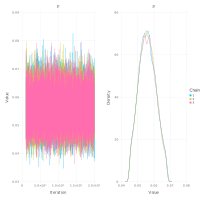

In [148]:
p0 = Mamba.plot(sim0, legend = true)
Mamba.draw(p0, nrow = 1, ncol = 2)

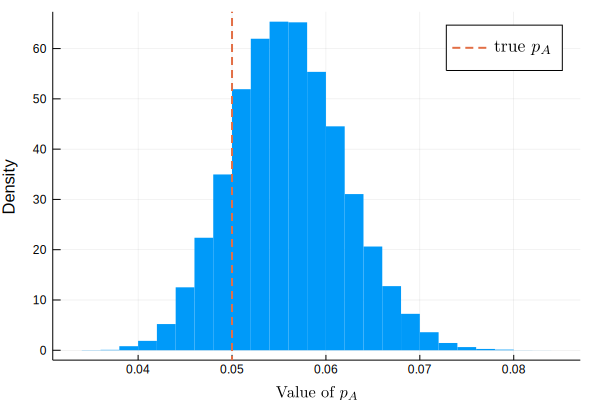

In [149]:
histogram(vec(sim0[:, :p, :].value), bins = 30, normalize = :pdf,
        linecolor = :transparent, label = "", xlabel = L"\mbox{Value of }p_A", ylabel = "Density")
plot!([p_true], seriestype = :vline, linestyle = :dash, linewidth = 2,
    label = L"\mbox{true }p_A", legendfontsize = 12)

### $N$を変えて事後分布の変化を見る
N=1500, 5000, 15000の3種類を試してみよう。

In [151]:
ab_sim = []
Ns = [1500, 5000, 15000]
for n in Ns
    ab_occur = rand(Bernoulli(p_true), n)
    ab_data = Dict{Symbol, Any}(
        :obs => ab_occur,
        :N => n,
    )
    ab_inits = [
        Dict{Symbol, Any}(
            :obs => ab_occur,
            :p => rand(Uniform()),
        ) for _ in 1:3
    ]
    push!(ab_sim, mcmc(model0, ab_data, ab_inits, 20000, 
                        burnin = 1000, thin = 1, chains = 3))
end

MCMC Simulation of 20000 Iterations x 3 Chains...

      From worker 4:	Chain 3:   0% [0:01:01 of 0:01:01 remaining]
      From worker 3:	Chain 1:   0% [0:01:30 of 0:01:30 remaining]
      From worker 2:	Chain 2:   0% [0:02:41 of 0:02:41 remaining]
      From worker 4:	Chain 3:  10% [0:00:36 of 0:00:40 remaining]
      From worker 2:	Chain 2:  10% [0:00:38 of 0:00:42 remaining]
      From worker 3:	Chain 1:  10% [0:00:38 of 0:00:43 remaining]
      From worker 4:	Chain 3:  20% [0:00:31 of 0:00:38 remaining]
      From worker 2:	Chain 2:  20% [0:00:32 of 0:00:40 remaining]
      From worker 3:	Chain 1:  20% [0:00:33 of 0:00:41 remaining]
      From worker 4:	Chain 3:  30% [0:00:27 of 0:00:38 remaining]
      From worker 2:	Chain 2:  30% [0:00:28 of 0:00:40 remaining]
      From worker 3:	Chain 1:  30% [0:00:29 of 0:00:42 remaining]
      From worker 4:	Chain 3:  40% [0:00:23 of 0:00:38 remaining]
      From worker 2:	Chain 2:  40% [0:00:24 of 0:00:40 remaining]
      From worker 3:	Chai

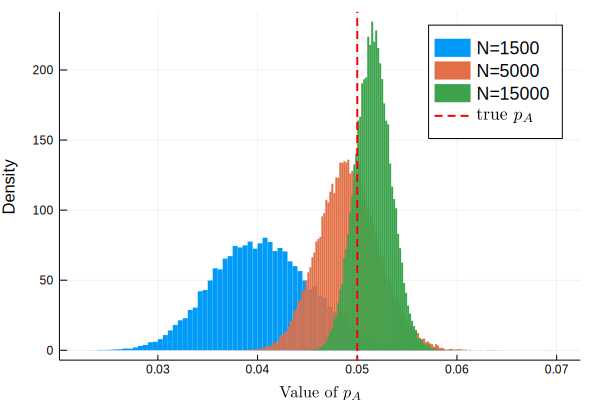

In [169]:
plot()
for (i, sim) in enumerate(ab_sim)
    histogram!(vec(sim[:, :p, :].value), normalize = :pdf,
            linecolor = :transparent, label = @sprintf("N=%d", Ns[i]), 
            xlabel = L"\mbox{Value of }p_A", ylabel = "Density")
end
plot!([p_true], seriestype = :vline, 
    linestyle = :dash, linewidth = 2, linecolor = :red,
    label = L"\mbox{true }p_A", legendfontsize = 12)